In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [3]:
loaded_model = tf.keras.models.load_model('model_1')

2022-06-05 05:03:08.290244: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-05 05:03:08.290314: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-40-90): /proc/driver/nvidia/version does not exist
2022-06-05 05:03:08.290914: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import wfdb

import matplotlib as plot
from scipy.signal import find_peaks
import shutil
import psutil
import pandas as pd  


In [125]:
path="download/physionet.org/files/mimic3wdb/1.0/39"
dirs= glob.glob(path+"/*")

In [126]:
files=glob.glob(dirs[0]+"/*")

In [127]:
url=files[15].replace(".hea","")
url=url.replace(".dat","")

print(url)

download/physionet.org/files/mimic3wdb/1.0/39/3957433/3957433_0008


In [128]:
signals, fields = wfdb.rdsamp(url)

In [129]:
ppg_i=fields['sig_name'].index("PLETH")
ecg_i=fields['sig_name'].index("II")
bp_i=fields['sig_name'].index("ABP")

In [130]:
a=signals[:,ppg_i]

In [134]:
a.shape

(275625,)

In [133]:
ppg_normalized.shape

(504212,)

In [5]:
ppg_list=[]
ecg_list=[]
bp_list=[]

In [6]:
sample_size=1000
ppg_min=50
ppg_max=150
ecg_min=5
ecg_max=25
dbp_lower=30
dbp_upper=110

sbp_upper=200
sbp_lower=80

mean_upper=140
mean_lower=50


def orgnize_data(arr,res):
    for i in range((int)(len(arr)/sample_size)):
        temp = arr[ i*sample_size:(i+1)*sample_size]
        res.append(temp)


In [137]:
orgnize_data(signals[:,ppg_i],ppg_list)
orgnize_data(signals[:,ecg_i],ecg_list)
orgnize_data(signals[:,bp_i],bp_list)
removed_index=[]

In [138]:
ppg_list[0]

array([0.20367323, 0.20175439, 0.19983552, 0.19928727, 0.20038377,
       0.20367323, 0.21052633, 0.22176535, 0.23821271, 0.26014254,
       0.2872807 , 0.31798246, 0.35087718, 0.38404606, 0.41611839,
       0.44544957, 0.47149121, 0.49342103, 0.51123903, 0.52521927,
       0.53508772, 0.54166664, 0.54550437, 0.54687499, 0.54632675,
       0.54413374, 0.54057016, 0.53591006, 0.53070175, 0.52494517,
       0.51918858, 0.5131579 , 0.50740131, 0.50191886, 0.49616228,
       0.48985745, 0.48327849, 0.47615131, 0.46847587, 0.45997808,
       0.45038377, 0.44024122, 0.42982457, 0.41940788, 0.40926533,
       0.39994516, 0.39144737, 0.38404606, 0.37774124, 0.37225875,
       0.36814692, 0.36485744, 0.36211624, 0.35992324, 0.35800437,
       0.35635963, 0.35498903, 0.35389253, 0.35252193, 0.35060307,
       0.34895832, 0.34731358, 0.34539472, 0.34320174, 0.34100876,
       0.33854166, 0.33580043, 0.33278508, 0.3294956 , 0.32648026,
       0.32373904, 0.32072367, 0.31743421, 0.31414473, 0.31085

In [77]:
            
for i in range(len(ppg_list)) :
    if np.any(np.isnan(ppg_list[i])):
        removed_index.append(i)
                    


for i in range(len(ecg_list)) :
    if not i in removed_index:
        if np.any(np.isnan(ecg_list[i])):
            removed_index.append(i)
                        
ppg=[]
ecg=[]
i_list=np.empty((0,0))
o_list=[]
for i in range(len(bp_list)) :
    if not i in removed_index:
        dbp_temp=min(bp_list[i])
        sbp_temp=max(bp_list[i])
                    
        if np.isnan(dbp_temp) or np.isnan(sbp_temp):                       
            removed_index.append(i)
        elif dbp_temp<dbp_lower or dbp_temp>dbp_upper:
            removed_index.append(i)
        elif sbp_temp<sbp_lower or sbp_temp>  sbp_upper:
            removed_index.append(i)
        else:
            bp=[dbp_temp,sbp_temp]
            o_list.append(bp)
                    
            
            
             
for i in range(len(ecg_list)):
    if not i  in removed_index:
        ecg.append(ecg_list[i])
                    
for i in range(len(ppg_list)):  
    if not i  in removed_index:
        ppg.append(ppg_list[i])          



In [83]:
np.std(ecg[0])

0.06267299474601493

In [84]:
np.std(ppg[0])

0.1362922064080254

In [16]:
            
i_list=np.hstack((np.array(ecg),np.array(ppg)))
o_list=np.array(o_list)

In [17]:
print(i_list[0]) 

[0.54011742 0.54011742 0.54011742 ... 0.39198436 0.38318671 0.37438905]


In [18]:
o_list.shape

(176, 2)

In [19]:
x_test=i_list
y_test=o_list

In [20]:
print(x_test.shape)
print(y_test.shape)


(176, 2000)
(176, 2)


In [21]:
y_predicted=loaded_model.predict(x_test)

In [25]:
y_predicted[0][0]

53.068375

In [18]:
from sklearn.metrics import mean_absolute_error as mae


In [34]:
mae(y_predicted,y_test)

17.088591964563527

In [35]:
y_test[:,0].shape


(3561,)

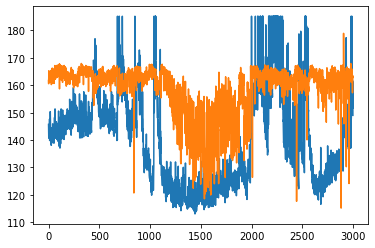

In [36]:
x=range(3000)
y=y_test[0:3000,1]
plt.plot(x,y)
x_1=range(3000)
y_1=y_predicted[0:3000,1]
plt.plot(x_1,y_1)
plt.show()

In [1]:
from shutil import make_archive
make_archive('model.zip', 'zip', "model_1")

'/home/ubuntu/project/model.zip.zip'

NameError: name 'i_list' is not defined

In [18]:
x=i_list[0].tolist()

In [21]:
x[999:1002]

[0.5998043052837574, 0.6197458455522972, 0.6471163245356794]

In [7]:
df = pd.read_csv('data.csv')

In [218]:
ecg

[array([0.65762712, 0.65988701, 0.66327684, 0.66440678, 0.66440678,
        0.66214689, 0.66101695, 0.66327684, 0.66214689, 0.65649718,
        0.65310734, 0.65084746, 0.65084746, 0.64858757, 0.64858757,
        0.64858757, 0.64632768, 0.64519774, 0.64632768, 0.64858757,
        0.65762712, 0.66892655, 0.69830508, 0.71412429, 0.71186441,
        0.68587571, 0.66214689, 0.62824859, 0.62033898, 0.6180791 ,
        0.61920904, 0.62259887, 0.63276836, 0.63954802, 0.64858757,
        0.65084746, 0.65310734, 0.65423729, 0.65423729, 0.65649718,
        0.65649718, 0.65762712, 0.65762712, 0.65988701, 0.66101695,
        0.66214689, 0.66327684, 0.66440678, 0.66666667, 0.66666667,
        0.66440678, 0.66440678, 0.66327684, 0.66101695, 0.65988701,
        0.65649718, 0.65423729, 0.64971751, 0.64858757, 0.64632768,
        0.64519774, 0.64632768, 0.64745763, 0.64971751, 0.6519774 ,
        0.6519774 , 0.65084746, 0.64858757, 0.64632768, 0.64293785,
        0.64067797, 0.63841808, 0.63728814, 0.63

In [8]:
df.head()

PPG       ABP   MAP    SBP   DBP       ECG
0  18.144077  112.5000  84.0  118.0  66.0 -0.114999
1  17.973139  110.6250  84.0  118.0  66.0 -0.114999
2  17.802198  108.8125  84.0  118.0  66.0 -0.114999
3  17.753357  107.0000  84.0  118.0  66.0 -0.114999
4  17.851038  105.2500  84.0  118.0  66.0 -0.114999

In [9]:
np.mean(ecg)

NameError: name 'ecg' is not defined

In [10]:
ppg=df["PPG"].to_numpy()
ecg=df["ECG"].to_numpy()

ppg_normalized=(ppg-np.min(ppg))/(np.max(ppg)-np.min(ppg))
ecg_normalized=(ecg-np.min(ecg))/(np.max(ecg)-np.min(ecg))

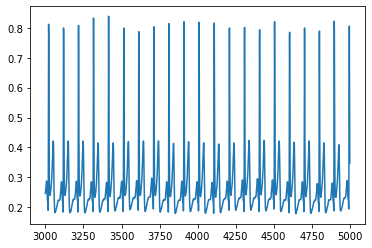

In [11]:
from matplotlib.pyplot import figure

x=range(3000,5000)
y=ecg_normalized[3000:5000]
plt.plot(x,y)

plt.show()

In [12]:
bp=df["ABP"].to_numpy()

In [13]:
orgnize_data(ppg_normalized,ppg_list)
orgnize_data(ecg_normalized,ecg_list)


In [17]:
removed_index=[]

In [14]:
orgnize_data(bp,bp_list)


In [18]:
for i in range(len(ppg_list)) :
    if np.any(np.isnan(ppg_list[i])):
        removed_index.append(i)
                    


for i in range(len(ecg_list)) :
    if not i in removed_index:
        if np.any(np.isnan(ecg_list[i])):
            removed_index.append(i)
                        
ppg=[]
ecg=[]
i_list=np.empty((0,0))
o_list=[]
for i in range(len(bp_list)) :
    if not i in removed_index:
        dbp_temp=min(bp_list[i])
        sbp_temp=max(bp_list[i])
                    
        if np.isnan(dbp_temp) or np.isnan(sbp_temp):                       
            removed_index.append(i)
        elif dbp_temp<dbp_lower or dbp_temp>dbp_upper:
            removed_index.append(i)
        elif sbp_temp<sbp_lower or sbp_temp>  sbp_upper:
            removed_index.append(i)
        else:
            bp=[dbp_temp,sbp_temp]
            o_list.append(bp)
                    
            
            
             
for i in range(len(ecg_list)):
    if not i  in removed_index:
        ecg.append(ecg_list[i])
                    
for i in range(len(ppg_list)):  
    if not i  in removed_index:
        ppg.append(ppg_list[i])          


In [19]:
i_list=np.hstack((np.array(ecg),np.array(ppg)))
o_list=np.array(o_list)

In [20]:
x_test=i_list
y_test=o_list

In [21]:
x_test.shape

(501, 2000)

In [22]:
y_test.shape

(501, 2)

In [23]:
y_predicted=loaded_model.predict(x_test)

In [24]:
from sklearn.metrics import mean_absolute_error as mae


In [25]:
mae(y_predicted,y_test)

5.866694309315451

In [26]:
y_test[:,0].shape


(501,)

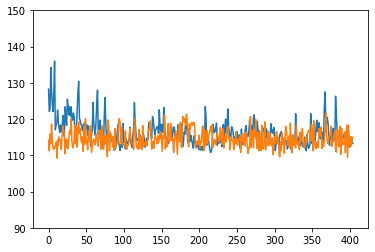

<Figure size 3000x800 with 0 Axes>

In [29]:
from matplotlib.pyplot import figure

x=range(405)
y=y_test[0:405,1]
plt.plot(x,y)
x_1=range(405)
y_1=y_predicted[0:405,1]
plt.plot(x_1,y_1)
plt.ylim(90,150)
figure(figsize=(15, 4), dpi=200)

plt.show()

In [161]:
def get_bp_mean(arr,res):
    for i in range((int)(len(arr)/sample_size)):
        temp = arr[ i*sample_size:(i+1)*sample_size]
        res.append( np.mean(temp))

In [181]:
sbp_mean=[]
dbp_mean=[]
get_bp_mean(df["SBP"].to_numpy(),sbp_mean)
get_bp_mean(df["DBP"].to_numpy(),dbp_mean)

In [182]:
final=[]

In [183]:
for i in range(len(sbp_mean)) :
    if not i in removed_index:
            bp=[sbp_mean[i],dbp_mean[i]]
            final.append(bp)

In [184]:
final=np.array(final)

In [185]:
final.shape

(405, 2)

In [186]:
mae(y_predicted,final)

56.43764779675183

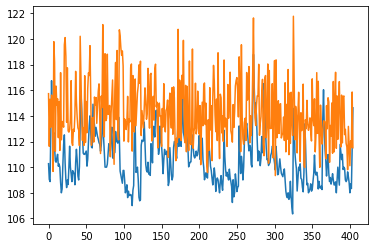

In [174]:
x=range(405)
y=sbp[0:405,0]
plt.plot(x,y)
x_1=range(405)
y_1=y_predicted[0:405,1]
plt.plot(x_1,y_1)
plt.show()

In [ ]:
x=range(405)
y=sbp[0:405,0]
plt.plot(x,y)
x_1=range(405)
y_1=y_predicted[0:405,1]
plt.plot(x_1,y_1)
plt.show()